## Command를 사용하여 제어 흐름과 상태 업데이트를 결합하는 방법
- 제어 흐름(엣지)과 상태 업데이트(노드)를 결합하는 것이 유용할 수 있음
  - 예를 들어, 상태 업데이트를 수행하는 동시에 같은 노드에서 다음 노드로 이동할 노드를 결정
- LangGraph에서는 `Command` 노드 함수에서 객체를 반환하여 이런 작업을 수행할 수 있음

### 기본 사용법

In [1]:
import random
from typing_extensions import TypedDict, Literal

from langgraph.graph import StateGraph, START
from langgraph.types import Command

# 그래프 상태 정의
class State(TypedDict):
    foo: str

# 노드 정의

def node_a(state: State) -> Command[Literal["node_b", "node_c"]]:
    print("Called A")
    value = random.choice(["a", "b"])
    # this is a replacement for a conditional edge function
    if value == "a":
        goto = "node_b"
    else:
        goto = "node_c"

    # note how Command allows you to BOTH update the graph state AND route to the next node
    return Command(
        # 상태 업데이트
        update={"foo": value},
        # this is a replacement for an edge
        goto=goto,
    )

def node_b(state: State):
    print("Called B")
    return {"foo": state["foo"] + "b"}

def node_c(state: State):
    print("Called C")
    return {"foo": state["foo"] + "c"}

위 노드를 사용하여 `StateGraph`를 생성할 수 있음
- 그래프에는 라우팅을 위한 Conditional_edge가 없다는 점
- 제어 흐름 내부에 `Command node_a`로 정의되어 있기 때문

In [2]:
builder = StateGraph(State)
builder.add_edge(START, "node_a")
builder.add_node(node_a)
builder.add_node(node_b)
builder.add_node(node_c)
# NOTE: there are no edges between nodes A, B and C!

graph = builder.compile()

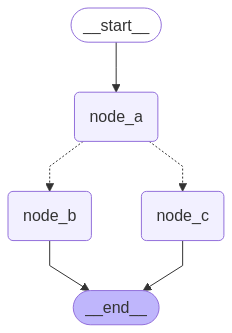

In [3]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
graph.invoke({"foo": ""})

Called A
Called B


{'foo': 'ab'}

### 부모 그래프의 노드로 이동

하위 그래프 내부에서 부모 그래프의 다른 노드로 이동하는 방법
- 위 예제를 단일 노드 `node_a` 그래프로 변경하고, 이를 부모 그래프의 하위 그래프로 추가

In [16]:
import operator
from typing_extensions import Annotated

class State(TypedDict):
    # NOTE: we define a reducer here
    foo: Annotated[str, operator.add]

def node_a(state: State):
    print("Called A")
    value = random.choice(["a", "b"])
    # this is a replacement for a conditional edge function
    if value == "a":
        goto = "node_b"
    else:
        goto = "node_c"

    # note how Command allows you to BOTH update the graph state AND route to the next node
    return Command(
        update={"foo": value},
        goto=goto,
        # this tells LangGraph to navigate to node_b or node_c in the parent graph
        # NOTE: this will navigate to the closest parent graph relative to the subgraph
        graph=Command.PARENT,
    )

subgraph = StateGraph(State).add_node(node_a).add_edge(START, "node_a").compile()

def node_b(state: State):
    print("Called B")
    # NOTE: since we've defined a reducer, we don't need to manually append
    # new characters to existing 'foo' value. instead, reducer will append these
    # automatically (via operator.add)
    return {"foo": "b"}

def node_c(state: State):
    print("Called C")
    return {"foo": "c"}

In [21]:
builder = StateGraph(State)
builder.add_edge(START, "subgraph")
builder.add_node("subgraph", subgraph)
builder.add_node(node_b)
builder.add_node(node_c)

graph = builder.compile()

In [22]:
graph.invoke({"foo": ""})

Called A
Called C


{'foo': 'bc'}